In [4]:
import xarray as xr
import importlib, os, gc, sys, glob
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
# import SXBQ as sx
import pandas as pd
import cmocean.cm as cmo
import glidertools as gt
import gsw
import gc
import os

from scipy.signal import find_peaks
from scipy.stats import linregress

## pretty colors:
import cmocean.cm as cmo
import matplotlib.colors as colors
import matplotlib.cm as cm

from argopy import DataFetcher as ArgoDataFetcher

from datetime import datetime as dt
import matplotlib.dates as mdates

import matplotlib.colors as cl
from matplotlib.colors import ListedColormap


import warnings
warnings.filterwarnings('ignore')


def grid2d(x, y, v, xi=1, yi=1, fn='median'):
    if np.size(xi) == 1:
        xi = np.arange(np.nanmin(x), np.nanmax(x)+xi, xi)
    if np.size(yi) == 1:
        yi = np.arange(np.nanmin(y), np.nanmax(y)+yi, yi)

    raw = pd.DataFrame({'x':x,'y':y,'v':v}).dropna()

    grid = np.full([np.size(yi),np.size(xi)], np.nan)
    
    raw['xbins'],xbin_iter = pd.cut(raw.x, xi,retbins=True,labels=False)
    raw['ybins'],ybin_iter = pd.cut(raw.y, yi,retbins=True,labels=False)

    _tmp = raw.groupby(['xbins','ybins'])['v'].agg(fn)
    grid[_tmp.index.get_level_values(1).astype(int),_tmp.index.get_level_values(0).astype(int)] = _tmp.values

    XI,YI = np.meshgrid(xi, yi, indexing='ij')
    return grid,XI.T,YI.T

# Show MWL algorithm for 1 float

In [5]:
NN_af=4
# yaxis_af=np.arange(0,1000,NN_af)
yaxis_af=np.arange(0,400,NN_af)

def mask(ArgoSet):
    msk=((ArgoSet.PSAL_QC==1) & (ArgoSet.PRES_QC==1) & (ArgoSet.TEMP_QC==1)).astype(float)
    msk[msk==0]=np.nan
    ArgoSet['PSAL_QC']=msk
    
def rolling_af(dff):
    tes=pd.DataFrame(dff).interpolate(limit=5, method='linear', axis=0).interpolate(limit=1, method='linear', axis=1).bfill()
    
    tes=tes.ffill(limit=1, axis=1).bfill(limit=1, axis=1).rolling(3, center=True, axis=1).median().to_numpy()
    return tes
    
def rolling_af_n2(dff):
    tes=pd.DataFrame(dff).interpolate(limit=5, method='linear', axis=0).interpolate(limit=1, method='linear', axis=1).bfill().rolling(3, center=True, axis=1).mean().to_numpy()
    return tes

def argo_process(ArgoSet):
    mask(ArgoSet)
    ArgoSet['abs_salinity'] = ('N_POINTS', gsw.SA_from_SP((ArgoSet['PSAL']*ArgoSet['PSAL_QC']).values,(ArgoSet['PRES']*ArgoSet['PSAL_QC']).values, ArgoSet['LONGITUDE'].values,ArgoSet['LATITUDE'].values))
    ArgoSet['cons_temp'] = ('N_POINTS',gsw.CT_from_t(ArgoSet['abs_salinity'].values,(ArgoSet['TEMP']*ArgoSet['PSAL_QC']).values,(ArgoSet['PRES']*ArgoSet['PSAL_QC']).values))
    ArgoSet['conductivity']=('N_POINTS', gsw.C_from_SP((ArgoSet['PSAL']*ArgoSet['PSAL_QC']).values,(ArgoSet['TEMP']*ArgoSet['PSAL_QC']).values, (ArgoSet['PRES']*ArgoSet['PSAL_QC']).values))    
    ArgoSet['potential_density'] = ('N_POINTS',gsw.sigma0(ArgoSet['abs_salinity'].values,ArgoSet['cons_temp'].values))
    ArgoSet['spice']=('N_POINTS', gsw.spiciness0(ArgoSet['abs_salinity'].values,ArgoSet['cons_temp'].values) )
    
    ArgoSet=ArgoSet.rename_vars({'TIME':'time', 'PRES':'pressure',  'LONGITUDE':'longitude',  'LATITUDE':'latitude', 'CYCLE_NUMBER':'profile_num' })
    ArgoSet=ArgoSet.swap_dims({"N_POINTS": "time"}) #.sel(TIME=slice("2021-12", "2022-03"))    
    
    return ArgoSet

def time_ax_argo(dff):
    yr_min=dff.time.dt.year.min().item()
    yr_max=dff.time.dt.year.max().item()
    
    time_ax=np.array([]).astype('datetime64[D]')
    for i in np.arange(yr_min, yr_max+1):
        time_ax=np.concatenate([time_ax,np.arange(np.datetime64(str(i)+'-01-01'), np.datetime64(str(i)+'-12-31'), np.timedelta64(10, "D"))])
    return time_ax
    
def argo_timeseries(dff, variable):
    time_ax=time_ax_argo(dff)
    # time_ax=np.arange(np.datetime64(str(yr_min)+'-01-01'), np.datetime64(str(yr_max)+'-12-31'), np.timedelta64(10, "D"))
    
    tes,x, y=grid2d(dff.time.values, dff.pressure.values, dff[variable].values, xi=time_ax, yi=yaxis_af, fn='median')
    tes=rolling_af(tes)
    # pd.DataFrame(tes).interpolate(limit=5, method='linear', axis=0).interpolate(limit=2, method='linear', axis=1).bfill().to_numpy()
    # .rolling(5, center=True, axis=0).mean().rolling(3, center=True, axis=1).mean().bfill().to_numpy()

    return tes

def argo_mld(dff):
    time_ax=time_ax_argo(dff)

    sig, xx, yy=grid2d(dff.time.values, dff.pressure.values, dff.potential_density.values, xi=time_ax, yi=yaxis_af)
    sig=rolling_af(sig)
    MLD= gt.physics.mixed_layer_depth(xx.flatten().astype(float), yy.flatten(), sig.flatten(), thresh=0.125, ref_depth=2) ## changed from 0.125 to 2m
    # MLD=pd.DataFrame(np.array(MLD)).interpolate().rolling(1,center=True).mean()[0].to_numpy()
    # MLD= gt.physics.mixed_layer_depth(xx.flatten().astype(float), yy.flatten(), sig.flatten(), thresh=0.05, ref_depth=10) ## changed from 0.125 to 2m

    return MLD


def argo_n2(dff):
    time_ax=time_ax_argo(dff)

    saa,x, y=grid2d(dff.time.values, dff.pressure.values, dff['abs_salinity'].values, xi=time_ax, yi=yaxis_af, fn='median')
    ctt,x, y=grid2d(dff.time.values, dff.pressure.values, dff['cons_temp'].values, xi=time_ax, yi=yaxis_af, fn='median')
    
    sa=saa.copy()
    sa1=sa*np.nan
    sa2=sa*np.nan
    
    sa1[:-1]=gsw.Nsquared(rolling_af(saa), rolling_af(ctt), y, axis=0)[0]
    sa2[:-1]=gsw.Nsquared(rolling_af_n2(saa), rolling_af_n2(ctt), y, axis=0)[0]
    
    return sa1, sa2


def argo_PV(dff):
    time_ax=time_ax_argo(dff)

    dff['density_in_situ']=gsw.rho(dff.abs_salinity, dff.cons_temp, dff.pressure)
    rho, xx, yy=grid2d(dff.time.values, dff.pressure.values, (dff['density_in_situ']).values, xi=time_ax, yi=yaxis_af)
    sigm, xx, yy=grid2d(dff.time.values, dff.pressure.values, (dff['potential_density']).values, xi=time_ax, yi=yaxis_af)
    lat, xx, yy=grid2d(dff.time.values, dff.pressure.values, (dff['latitude']).values, xi=time_ax, yi=yaxis_af)
    
    rho=rolling_af(rho)
    sigm=rolling_af(sigm)
    
    f_param=gsw.f(np.nanmean(lat))
    sig=(sigm.copy())*np.nan
    sig[:-1, :]=f_param*rho[:-1, :]*(np.diff(sigm, axis=0)/NN_af)
    # sig=rolling_(sig)    
        
    # sig=pd.DataFrame(sig).interpolate(limit=5, method='linear', axis=0).interpolate(limit=5, method='linear', axis=1).rolling(5, center=True, axis=0).mean().rolling(3, center=True, axis=1).mean().bfill().to_numpy()
    return sig

def gridded_df_af(dff):
    time_ax=time_ax_argo(dff)

    daf_g = xr.Dataset(
    data_vars=dict(
        potential_density=(["pressure", "time"], argo_timeseries(dff,  'potential_density')),
        abs_salinity=(["pressure", "time"], argo_timeseries(dff,  'abs_salinity')),
        cons_temp=(["pressure", "time"], argo_timeseries(dff,  'cons_temp')),
        latitude=(["pressure", "time"], argo_timeseries(dff,  'latitude')),
        longitude=(["pressure", "time"], argo_timeseries(dff,  'longitude')),

        N2=(["pressure", "time"], argo_n2(dff)[0]),
        N2_roll=(["pressure", "time"], argo_n2(dff)[1]),
        
        PV=(["pressure", "time"], argo_PV(dff)),
        
        mixed_layer_depth=("time", argo_mld(dff) )
    ),
    coords=dict(
        pressure=yaxis_af,
        time=time_ax,
    ),)    
    return daf_g


def gridded_df_af_BGQ(dff):
    time_ax=time_ax_argo(dff)

    daf_g = xr.Dataset(
    data_vars=dict(
        potential_density=(["pressure", "time"], argo_timeseries(dff,  'potential_density')),
        abs_salinity=(["pressure", "time"], argo_timeseries(dff,  'abs_salinity')),
        cons_temp=(["pressure", "time"], argo_timeseries(dff,  'cons_temp')),
        latitude=(["pressure", "time"], argo_timeseries(dff,  'latitude')),
        longitude=(["pressure", "time"], argo_timeseries(dff,  'longitude')),
        oxygen_concentration=(["pressure", "time"], argo_timeseries(dff,  'oxygen_concentration')),

        N2=(["pressure", "time"], argo_n2(dff)[0]),
        N2_roll=(["pressure", "time"], argo_n2(dff)[1]),
        
        PV=(["pressure", "time"], argo_PV(dff)),
        
        mixed_layer_depth=("time", argo_mld(dff) )
    ),
    coords=dict(
        pressure=yaxis_af,
        time=time_ax,
    ),)    
    return daf_g

def regrid_to_2D(variable):
    pr=(df_argo_prepros.pressure)*np.nan
    pr.T[0]=df_argo_prepros[variable]
    pr=pr.ffill('n_levels')
    return pr

def mask_bgq(ArgoSet):
    msk=((ArgoSet.DOXY_ADJUSTED_QC==1)).astype(float)
    msk[msk==0]=np.nan
    ArgoSet['DOXY_ADJUSTED_QC']=msk
    
def argo_process_bgq(ArgoSet):
    ArgoSet=ArgoSet.set_coords(['latitude', 'longitude'])
    mask_bgq(ArgoSet)    
    ArgoSet['abs_salinity'] = ('time', gsw.SA_from_SP((ArgoSet['salinity']).values,(ArgoSet['pressure']).values, ArgoSet['longitude'].values,ArgoSet['latitude'].values))
    ArgoSet['cons_temp'] = ('time',gsw.CT_from_t(ArgoSet['abs_salinity'].values,(ArgoSet['temperature']).values,(ArgoSet['pressure']).values))
    ArgoSet['potential_density'] = ('time',gsw.sigma0(ArgoSet['abs_salinity'].values,ArgoSet['cons_temp'].values))
    ArgoSet['oxygen_concentration'] =ArgoSet['DOXY_ADJUSTED']*ArgoSet['DOXY_ADJUSTED_QC']
    
    return ArgoSet


def _get_bottom_top_mode_water(float_):
    float_['dens_baseml']=float_.sel(pressure=(float_.mixed_layer_depth.ffill('time').bfill('time'))+4).potential_density
    # float_['dens_baseml']=float_.sel(pressure=(float_.mixed_layer_depth.ffill('time').bfill('time'))).potential_density
    
    plt.figure(figsize=(25,5))
    plt.plot(float_.time, float_['dens_baseml'])
    plt.plot(float_.time, float_['dens_baseml'].rolling(time=1, center=True).median(), c='k')

    if (float_.latitude.mean().values>20) == True:
        dist_to_find_peaks=10*2
    else: 
        dist_to_find_peaks=10
 

    rol_dens=float_['dens_baseml'].rolling(time=1, center=True).median()
    peaks, _ = find_peaks(rol_dens, distance=dist_to_find_peaks) #distance=20)
    plt.scatter(float_.time[peaks], rol_dens[peaks], c='r', zorder=10)

    DEN_ARR=np.arange(len(float_.time))*0.0
    peaks=np.concatenate([[0], peaks])
    DEN_ARR[peaks]=rol_dens[peaks]

    float_['density_MW']=('time', DEN_ARR)
    float_['density_MW'][DEN_ARR==0]=np.nan
    float_['density_MW']=float_['density_MW'].ffill('time')

    float_['mwd']=('time',(np.ma.masked_invalid(np.abs(float_['potential_density']-float_['density_MW']))[:].argmin(axis=0))*NN_af)
    float_['mwd']=float_['mwd'].astype(float)
    float_['mwd'][float_['mwd']==0]=np.nan
    float_['mwd'][float_['mwd'].values<float_['mixed_layer_depth'].values]=float_['mixed_layer_depth'][float_['mwd'].values<float_['mixed_layer_depth'].values]
    float_['mixed_layer_depth'][float_['mixed_layer_depth']==0]=np.nan

    minn2, bot_array, top_array=[],[],[]

    vmini, vmaxi=0, len(float_.time)
    for N in range(vmini,vmaxi):
        if ((np.isfinite(float_.mixed_layer_depth[N])==False) or (np.isfinite(float_.mwd[N])==False)):
                        minn2.append(np.nan)
                        bot_array.append(np.nan)
                        top_array.append(np.nan)   
        else:
            n2_prof=1/np.abs(float_.N2_roll[int(float_.mixed_layer_depth[N]/NN_af)+2:int(float_.mwd[N]/NN_af)-1, N][::-1])
            if len(n2_prof)<1:
                minn2.append(np.nan)
                bot_array.append(np.nan)
                top_array.append(np.nan)   

            else:
                peaks_n2=int(float_.mwd[N]/NN_af)-2-np.argmax(n2_prof.values)    

                sig_pfog=float_.potential_density[:, N]
                refdpt=peaks_n2

                bot_lay=gt.physics.mixed_layer_depth(np.ones(len(yaxis_af)), yaxis_af, sig_pfog, thresh=0.05, ref_depth=refdpt*NN_af)

                siginv=28-sig_pfog[:refdpt][::-1]
                yinv=np.arange(len(siginv))

                top_lay=gt.physics.mixed_layer_depth(np.ones(len(yinv)), yinv, siginv, thresh=0.05, ref_depth=0)  ##### TOP_LAY= (refddpt-13)*2
                # print(bot_lay, top_lay)

                bott=bot_lay[1]
                topp=(refdpt-top_lay[1])*NN_af

                minn2.append(refdpt*NN_af)
                bot_array.append(bott)
                top_array.append(topp)   
                # print(N)
    float_['top_mwl']=('time', np.array(top_array))
    float_['bot_mwl']=('time', np.array(bot_array))    
    float_['min_n2']=('time', np.array(minn2))    
    
    
    float_['top_mwl'][float_['top_mwl'].values<float_['mixed_layer_depth'].values]=float_['mixed_layer_depth'][float_['top_mwl'].values<float_['mixed_layer_depth'].values]

    return float_

##  Load data

In [6]:
df_argo=xr.open_dataset('/home/jupyter-estelfont/datasets/argo/datasets/ARGO_30_80_-5_30_2001_2023_fetcher.nc')

def mask(ArgoSet):
    msk=((ArgoSet.PSAL_QC==1) & (ArgoSet.PRES_QC==1) & (ArgoSet.TEMP_QC==1)).astype(float)
    msk[msk==0]=np.nan
    ArgoSet['PSAL_QC']=msk

    
def argo_process(ArgoSet):
    mask(ArgoSet)
    ArgoSet['abs_salinity'] = ('time', gsw.SA_from_SP((ArgoSet['PSAL']*ArgoSet['PSAL_QC']).values,(ArgoSet['pressure']*ArgoSet['PSAL_QC']).values, ArgoSet['longitude'].values,ArgoSet['latitude'].values))
    ArgoSet['cons_temp'] = ('time',gsw.CT_from_t(ArgoSet['abs_salinity'].values,(ArgoSet['TEMP']*ArgoSet['PSAL_QC']).values,(ArgoSet['pressure']*ArgoSet['PSAL_QC']).values))
    # ArgoSet['conductivity']=('time', gsw.C_from_SP((ArgoSet['PSAL']*ArgoSet['PSAL_QC']).values,(ArgoSet['TEMP']*ArgoSet['PSAL_QC']).values, (ArgoSet['pressure']*ArgoSet['PSAL_QC']).values))    
    ArgoSet['potential_density'] = ('time',gsw.sigma0(ArgoSet['abs_salinity'].values,ArgoSet['cons_temp'].values))
    # ArgoSet['spice']=('time', gsw.spiciness0(ArgoSet['abs_salinity'].values,ArgoSet['cons_temp'].values) )    
    
    ArgoSet=ArgoSet.rename_vars({'PLATFORM_NUMBER':'platform_num' })    
    return ArgoSet

df_argo=argo_process(df_argo)

vars_to_drop=['CONFIG_MISSION_NUMBER',
 'DATA_MODE',
 'DIRECTION',
 'POSITION_QC',
 'PRES_QC',
 'PSAL',
 'PSAL_QC',
 'TEMP',
 'TEMP_QC',
 'TIME_QC',
 'N_POINTS',
 'conductivity',
 'spice']

df_argo=df_argo.drop_vars(vars_to_drop)
df_argo=df_argo.where(df_argo.potential_density>20).where(df_argo.potential_density<30).where(df_argo.abs_salinity>34).where(df_argo.cons_temp>5)
# grid per platform
ds_platform_num=df_argo.groupby('platform_num')

del df_argo
gc.collect()

PlatformNum=list(ds_platform_num.groups.keys())
platforms_good=[]
for i in tqdm(PlatformNum):
    dff=ds_platform_num[i]
    num_days=((dff.time.max()-dff.time.min()).astype('timedelta64[D]')/np.timedelta64(1, 'D')).item()
    lat, lon=np.nanmean(dff.latitude), np.nanmean(dff.longitude)
    if (num_days>(30*3)):
    # if (num_days>(30*3)) & (lat>10):
        platforms_good.append(i)
        
platforms_numbers=np.array(platforms_good)

len(platforms_numbers)

  0%|          | 0/678 [00:00<?, ?it/s]

579

In [ ]:
# for i in range(0, len(platforms_numbers)):
#     float_1=ds_platform_num[platforms_numbers[i]]#206
#     float_1=gridded_df_af(float_1)
#     plt.title(str(i)+'  '+str(float_1.time[0].dt.year.item())+'  '+str(float_1.time[-1].dt.year.item()))
#     plt.scatter(float_1.longitude,float_1.latitude)
#     plt.ylim(5,30)
#     plt.xlim(40,75)
#     plt.show()

## Process 1 float

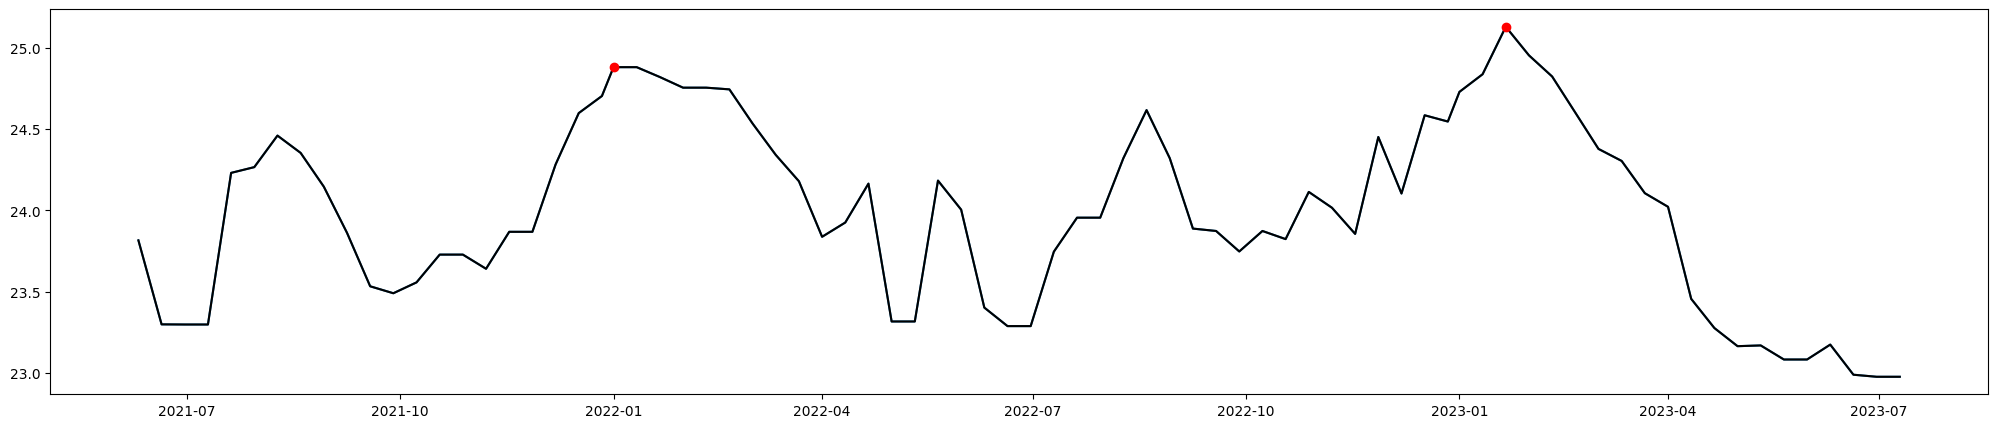

In [7]:
float_1=ds_platform_num[6903059] #2901444] #2901427] #2901465]#206 268 220 230
float_1=gridded_df_af(float_1)
float_1=_get_bottom_top_mode_water(float_1)

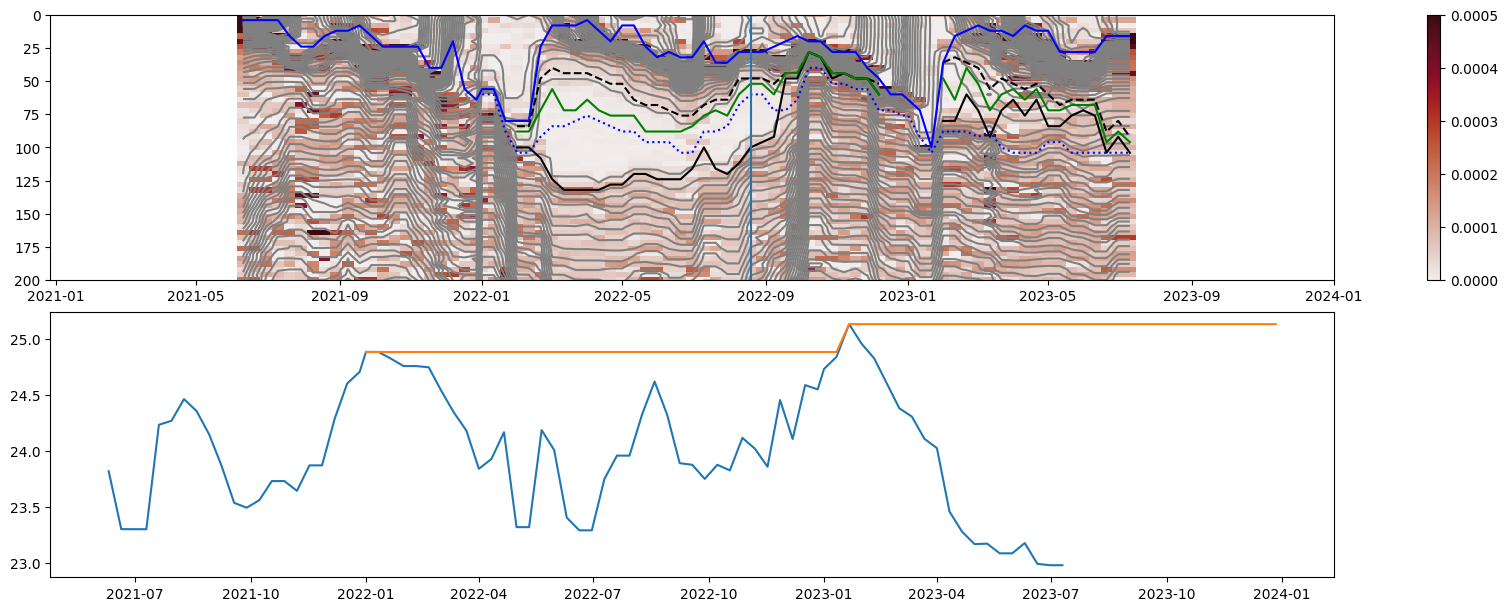

In [8]:
plt.figure(figsize=(15,6), constrained_layout=True)
plt.subplot(211)
plt.pcolormesh(float_1.time, float_1.pressure, float_1.N2, vmin=0, vmax=0.0005, cmap=cmo.amp)
# plt.pcolormesh(float_1.time, float_1.pressure, float_1.oxygen_concentration, vmin=0, vmax=200, cmap=cmo.dense)
plt.colorbar()

plt.contour(float_1.time, float_1.pressure, float_1.potential_density, levels=np.arange(22, 28, 0.05), colors='gray')
# plt.pcolormesh(float_1.time, float_1.pressure, float_1.oxygen_concentration, cmap=cmo.dense)

# plt.pcolormesh(float_1.time, float_1.pressure, float_1.cons_temp, cmap=cmo.thermal, vmin=13, vmax=32)

plt.ylim(200,0)

plt.plot(float_1.time,float_1.bot_mwl, c='k')
plt.plot(float_1.time,float_1.top_mwl, c='k', ls='--')
plt.plot(float_1.time,float_1.min_n2, c='g')
plt.plot(float_1.time,float_1.mwd, c='b', ls=':')
# plt.xlim(pd.to_datetime('2014-01'), pd.to_datetime('2017-06'))
# plt.xlim(pd.to_datetime('2010-01'), pd.to_datetime('2015-06'))

# plt.plot(float_1.time,float_1.mwd, c='g')

plt.plot(float_1.time,float_1.mixed_layer_depth, c='b')
N=60
plt.axvline(float_1.time.values[N])

plt.subplot(212)
plt.plot(float_1.time, float_1.dens_baseml)
plt.plot(float_1.time, float_1.density_MW)
# plt.xlim(pd.to_datetime('2010-01'), pd.to_datetime('2015-06'))
# plt.ylim(200,0)

# plt.xlim(pd.to_datetime('2014-01'), pd.to_datetime('2017-06'))


In [ ]:
# float_1=_get_bottom_top_mode_water(float_1)

<xarray.DataArray 'min_n2' ()>
array(52.)
Coordinates:
    time     datetime64[ns] 2022-08-19


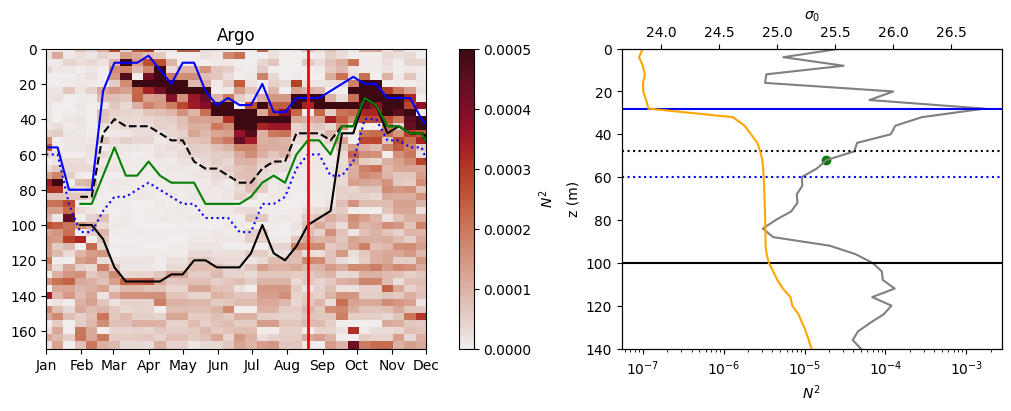

In [10]:
plt.figure(figsize=(10,4), constrained_layout=True)
plt.subplot(121)
plt.title('Argo')

plt.pcolormesh(float_1.time, float_1.pressure, float_1.N2, vmin=0, vmax=0.0005, cmap=cmo.amp)
# plt.pcolormesh(float_1.time, float_1.pressure, float_1.abs_salinity,  cmap=cmo.dense)
cb=plt.colorbar()
cb.set_label('$N^2$')

# plt.contour(float_1.time, float_1.pressure, float_1.oxygen_concentration, levels=[120], colors='w', linestyles=':')
# plt.contour(float_1.time, float_1.pressure, float_1.oxygen_concentration, levels=[60], colors='w')

# plt.pcolormesh(float_1.time, float_1.pressure, float_1.cons_temp, cmap=cmo.thermal, vmin=13, vmax=32)

plt.ylim(170,0)

plt.plot(float_1.time,float_1.bot_mwl, c='k')
plt.plot(float_1.time,float_1.top_mwl, c='k', ls='--')
plt.plot(float_1.time,float_1.min_n2, c='g')
plt.plot(float_1.time,float_1.mwd, c='b', ls=':')

# plt.plot(float_1.time,float_1.mwd, c='g')

plt.plot(float_1.time,float_1.mixed_layer_depth, c='b')
# N=100
plt.axvline(float_1.time.values[N], c='r', lw=2)

plt.xlim(pd.to_datetime('2022-01'), pd.to_datetime('2022-12'))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    # ax2.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY, interval=3))
    
plt.subplot(122)
float_=float_1
# N=88
print(float_.min_n2[N])
# plt.figure(figsize=(3,4))

plt.plot(np.abs(float_.N2_roll[:, N]), yaxis_af, c='gray')
# plt.xlim(0,0.1e6)
# plt.axvline(0, c='gray')
plt.xscale('log')
plt.ylabel('z (m)')

plt.axhline(float_.mixed_layer_depth[N], c='b')
plt.axhline(float_.mwd[N], c='b', ls=':')
# plt.axhline(float_.mwd[N]-4, c='b')
plt.xlabel('$N^2$')
plt.axhline(float_.top_mwl[N], c='k', ls=':')
plt.axhline(float_.bot_mwl[N], c='k')
plt.scatter(float_.N2_roll[:, N][int(float_.min_n2[N]/NN_af)], yaxis_af[int(float_.min_n2[N]/NN_af)], c='g')

plt.twiny()
plt.plot(float_.potential_density[:, N], yaxis_af, c='orange')
# for i in np.arange(24.8,25.3, 0.05):
#     plt.axvline(i, alpha=0.5)
plt.xlabel('$\sigma_0$')

# plt.xlim(23.5, 25.5)
# plt.twiny()
# plt.plot(float_.oxygen_concentration[:, N], yaxis_af, c='b')

plt.ylim(140,0)


# sig_pfog=float_.potential_density[:, N]
# refdpt=peaks_n2
# print(refdpt)
# bot_lay=gt.physics.mixed_layer_depth(np.ones(len(yaxis)), yaxis, sig_pfog, thresh=0.05, ref_depth=refdpt*2)

# siginv=28-sig_pfog[:refdpt][::-1]
# yinv=np.arange(len(siginv))

# top_lay=gt.physics.mixed_layer_depth(np.ones(len(yinv)), yinv, siginv, thresh=0.05, ref_depth=0)  ##### TOP_LAY= (refddpt-13)*2
# print(bot_lay, top_lay)

# plt.axhline(bot_lay[1], c='r')
# plt.axhline((refdpt-top_lay[1])*2, c='r', ls=':')
plt.show()

## Process ALL argo in the Arabian Sea between 2000 and 2023

In [13]:
df_argo=xr.open_dataset('/home/jupyter-estelfont/datasets/argo/datasets/ARGO_30_80_-5_30_2001_2023_fetcher.nc')

def mask(ArgoSet):
    msk=((ArgoSet.PSAL_QC==1) & (ArgoSet.PRES_QC==1) & (ArgoSet.TEMP_QC==1)).astype(float)
    msk[msk==0]=np.nan
    ArgoSet['PSAL_QC']=msk

def argo_process(ArgoSet):
    mask(ArgoSet)
    ArgoSet['abs_salinity'] = ('time', gsw.SA_from_SP((ArgoSet['PSAL']*ArgoSet['PSAL_QC']).values,(ArgoSet['pressure']*ArgoSet['PSAL_QC']).values, ArgoSet['longitude'].values,ArgoSet['latitude'].values))
    ArgoSet['cons_temp'] = ('time',gsw.CT_from_t(ArgoSet['abs_salinity'].values,(ArgoSet['TEMP']*ArgoSet['PSAL_QC']).values,(ArgoSet['pressure']*ArgoSet['PSAL_QC']).values))
    # ArgoSet['conductivity']=('time', gsw.C_from_SP((ArgoSet['PSAL']*ArgoSet['PSAL_QC']).values,(ArgoSet['TEMP']*ArgoSet['PSAL_QC']).values, (ArgoSet['pressure']*ArgoSet['PSAL_QC']).values))    
    ArgoSet['potential_density'] = ('time',gsw.sigma0(ArgoSet['abs_salinity'].values,ArgoSet['cons_temp'].values))
    # ArgoSet['spice']=('time', gsw.spiciness0(ArgoSet['abs_salinity'].values,ArgoSet['cons_temp'].values) )    
    
    ArgoSet=ArgoSet.rename_vars({'PLATFORM_NUMBER':'platform_num' })    
    return ArgoSet

df_argo=argo_process(df_argo)

vars_to_drop=['CONFIG_MISSION_NUMBER',
 'DATA_MODE',
 'DIRECTION',
 'POSITION_QC',
 'PRES_QC',
 'PSAL',
 'PSAL_QC',
 'TEMP',
 'TEMP_QC',
 'TIME_QC',
 'N_POINTS',
 'conductivity',
 'spice']

df_argo=df_argo.drop_vars(vars_to_drop)
df_argo=df_argo.where(df_argo.potential_density>20).where(df_argo.potential_density<30).where(df_argo.abs_salinity>33).where(df_argo.cons_temp>2)

# grid per platform
ds_platform_num=df_argo.groupby('platform_num')

del df_argo
gc.collect()

PlatformNum=list(ds_platform_num.groups.keys())
platforms_good=[]
for i in tqdm(PlatformNum):
    dff=ds_platform_num[i]
    num_days=((dff.time.max()-dff.time.min()).astype('timedelta64[D]')/np.timedelta64(1, 'D')).item()
    lat, lon=np.nanmean(dff.latitude), np.nanmean(dff.longitude)
    if (num_days>(30*3)):# & (lat>10):
        platforms_good.append(i)
        
platforms_numbers=np.array(platforms_good)

len(platforms_numbers)

  0%|          | 0/678 [00:00<?, ?it/s]

579

In [18]:
# platforms_numbers

In [16]:
# def make_nc_dataset_argos_wwl():
#     m=0
#     float_init=0
#     float_1=ds_platform_num[platforms_numbers[m]]#206 268 220 230
#     float_2=gridded_df_af(float_1)
#     float_3=_get_bottom_top_mode_water(float_2)
#     df_arg_all= float_3.assign_coords({"platform_num":platforms_numbers[m]}).expand_dims("platform_num")
#     # df_arg_all.to_netcdf('bgq_argo_wwl_'+str(float_init)+'_'+str(m)+'floats.nc')    
#     # del float_1
#     for plt_ in tqdm(platforms_numbers[1:len(platforms_numbers)+1]):
#         # print(plt_)
#         m=m+1
#         # df_arg_all=xr.open_dataset('bgq_argo_wwl_'+str(float_init)+'_'+str(m-1)+'floats.nc')
#         float_1=ds_platform_num[plt_]#206 268 220 230
#         if (np.count_nonzero(np.isfinite(float_1.pressure))!=0):
#             float_2=gridded_df_af(float_1)
#             if (np.count_nonzero(np.isfinite(float_2.mixed_layer_depth))!=0):
#                 float_3=_get_bottom_top_mode_water(float_2)
#                 float_4= float_3.assign_coords({"platform_num":plt_}).expand_dims("platform_num")    
#                 df_arg_all=xr.merge([df_arg_all, float_4])
#                 # df_arg_all.to_netcdf('bgq_argo_wwl_'+str(float_init)+'_'+str(m)+'floats.nc')    
#                 # gc.collect()
#                 # os.remove('bgq_argo_wwl_'+str(float_init)+'_'+str(m-1)+'floats.nc')
#         else:
#             print(plt_,  ' didnt work!')

#     df_arg_all.to_netcdf('argo_wwl_'+str(float_init)+'_'+str(m)+'floats.nc')   

In [63]:
def make_nc_dataset_argos_wwl(float_init, float_final):
    # float init, yr 1st:
    for plt_ in platforms_numbers[float_init:float_init+1]:
        fr_plt=ds_platform_num[plt_].groupby('time.year')
        years_=list(fr_plt.groups.keys())    
        for yr_ in years_[:1]:
            fr_plt_yr=fr_plt[yr_]
            # print(np.nanmean(fr_plt[yr_].latitude))
            df_arg=gridded_df_af(fr_plt_yr, str(yr_))
            if np.count_nonzero(~np.isnan(df_arg.abs_salinity))!=0:
                df_arg=get_max_dense(df_arg, NN_af, 1) 
                df_arg_all= df_arg.assign_coords({"platform_num":plt_}).expand_dims("platform_num")

    # float init, yr 2nd -last:
    for plt_ in platforms_numbers[float_init:float_init+1]:
        fr_plt=ds_platform_num[plt_].groupby('time.year')
        years_=list(fr_plt.groups.keys())    
        for yr_ in years_[1:]:
            fr_plt_yr=fr_plt[yr_]
            num_days=((fr_plt_yr.time.max()-fr_plt_yr.time.min()).astype('timedelta64[D]')/np.timedelta64(1, 'D')).item()
            if (num_days >3*30):
                # print(np.nanmean(fr_plt[yr_].latitude))
                df_arg=gridded_df_af(fr_plt_yr, str(yr_))     
                if np.count_nonzero(~np.isnan(df_arg.abs_salinity))!=0:
                    df_arg=get_max_dense(df_arg, NN_af, 1) 
                    df_arg= df_arg.assign_coords({"platform_num":plt_}).expand_dims("platform_num")
                    df_arg_all=xr.merge([df_arg_all, df_arg])
   
    # save nc with float init, yr 2nd -last:
    df_arg_all.to_netcdf('argo_wwl_'+str(float_init)+'_'+str(float_init)+'floats.nc')    

    # # # all the rest!:
    for NN_s in tqdm(range(float_init+1, float_final,1)):
        df_arg_all=xr.open_dataset('argo_wwl_'+str(float_init)+'_'+str(NN_s-1)+'floats.nc')
        plt_=platforms_numbers[NN_s]
        # print(NN_s, plt_)
        fr_plt=ds_platform_num[plt_].groupby('time.year')
        years_=list(fr_plt.groups.keys())
        for yr_ in years_:
            fr_plt_yr=fr_plt[yr_]
            num_days=((fr_plt_yr.time.max()-fr_plt_yr.time.min()).astype('timedelta64[D]')/np.timedelta64(1, 'D')).item()
            if (num_days>90):
                df_arg=gridded_df_af(fr_plt_yr, str(yr_))   
                del fr_plt_yr
                if np.count_nonzero(~np.isnan(df_arg.abs_salinity.values))!=0:
                    df_arg=get_max_dense(df_arg, NN_af, 1) 
                    df_arg= df_arg.assign_coords({"platform_num":plt_}).expand_dims("platform_num")
                    df_arg_all=xr.merge([df_arg_all, df_arg])
                    del df_arg
            gc.collect()

        del fr_plt
        gc.collect()

        df_arg_all.to_netcdf('argo_wwl_'+str(float_init)+'_'+str(NN_s)+'floats.nc')   
        os.remove('argo_wwl_'+str(float_init)+'_'+str(NN_s-1)+'floats.nc')

In [93]:
## prccess a few floats a time steps:)) with 100 floats wach cause v heavyyy -- takes like... 5-6min each!

# make_nc_dataset_argos_wwl(0,100)
# make_nc_dataset_argos_wwl(100,200)
# make_nc_dataset_argos_wwl(200,273)..

In [ ]:
# # # # ## process 2: MERGE ALL and process WWL prop!

# # ## if core

# df_arg_1=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/argo_wwl_per_yr/L0/argo_wwl_0_99floats_v5.nc')
# df_arg_2=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/argo_wwl_per_yr/L0/argo_wwl_100_199floats_v5.nc')
# df_arg_3=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/argo_wwl_per_yr/L0/argo_wwl_200_272floats_v5.nc')

# df_arg_all=xr.merge([df_arg_1, df_arg_2, df_arg_3])


In [ ]:
# # ## MASK WWL PROPERTIES:
def mask_wwl(df):
    msk_wwl=np.array(((df.pressure<df.wwl_bottom) & (df.pressure>df.wwl_top)).astype(float)).swapaxes(0,1)
    msk_wwl[msk_wwl==0]=np.nan
    # msk_thick=(df['wwl_thickness']>20).astype(float)
    # msk_thick[msk_thick==0]=np.nan
    df['wwl_msk']=(['platform_num','pressure',  'time'], msk_wwl)
    # df['wwl_msk']=df['wwl_msk']*msk_thick)

def process_wwl_basic(df, N_):
    df['wwl_top_n2']=df['wwl_top_n2'].interpolate_na('time', limit=5)
    df['wwl_thickness_n2']=df.wwl_bottom-df.wwl_top_n2    
    
    df['wwl_top']=df['wwl_top'].interpolate_na('time', limit=5)
    df['wwl_thickness']=df.wwl_bottom-df.wwl_top    
   
    df['N2_integral']= (('platform_num',"time"), (np.nansum(df.N2*df.wwl_msk*N_, axis=1)/df.wwl_thickness).values)
    df['SA_wwl']=(('platform_num',"time"), np.nanmean(df.abs_salinity.values*df.wwl_msk.values, axis=1))
    df['CT_wwl']=(('platform_num',"time"), np.nanmean(df.cons_temp.values*df.wwl_msk.values, axis=1))
    df['sigma_wwl']=(('platform_num',"time"),np.nanmean(df.potential_density.values*df.wwl_msk.values, axis=1))


mask_wwl(df_arg_all)
process_wwl_basic(df_arg_all, NN_af)

process_wwl_bgq(df_arg_all, NN_af)

# # ## if core
df_arg_all.to_netcdf('/home/jupyter-estelfont/MWL_chapter/argo_wwl_per_yr/L1/ARGO_MWL.nc')
